<a href="https://colab.research.google.com/github/AbdulQadoos-Lab/Abdul_WorkStation/blob/main/Stock_Predict_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implementation of FFNN, CNN, LSTM and GRU with hypermeter tuning**

In [38]:
import pandas as pnd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import yfinance as yf

In [39]:
# Load data
data = yf.download('AAPL', start='2019-01-01', end='2025-01-01')
#data = yf.download('GOOG', start='2019-01-01', end='2025-01-01')
#data = yf.download('TSLA', start='2019-01-01', end='2025-01-01')

/tmp/ipython-input-39-4270437615.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2019-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


In [40]:
data.reset_index(inplace=True)

data['Price_Change'] = (data['High'] - data['Low']) / data['Close']
data['SMA_30'] = data['Close'].rolling(window=30).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data.fillna(0, inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change', 'SMA_30', 'SMA_50']
target = 'Close'


In [41]:
print(data[features])

Price         Open        High         Low       Close     Volume  \
Ticker        AAPL        AAPL        AAPL        AAPL       AAPL   
0        36.896080   37.839387   36.738862   37.617851  148158800   
1        34.297229   34.711713   33.825578   33.870838  365248800   
2        34.428241   35.385840   34.254350   35.316757  234428400   
3        35.421581   35.452549   34.754597   35.238159  219111200   
4        35.626428   36.164781   35.378693   35.909897  164101200   
...            ...         ...         ...         ...        ...   
1505    254.875189  257.588630  254.675658  257.578674   23234700   
1506    257.568678  259.474086  257.010028  258.396667   27237100   
1507    257.209530  258.077462  252.451019  254.974930   42355300   
1508    251.623005  252.889953  250.146571  251.593079   35557500   
1509    251.832511  252.670486  248.829744  249.817368   39480700   

Price  Price_Change      SMA_30      SMA_50  
Ticker                                       
0         

In [42]:
print(data[[target]])

Price        Close
Ticker        AAPL
0        37.617851
1        33.870838
2        35.316757
3        35.238159
4        35.909897
...            ...
1505    257.578674
1506    258.396667
1507    254.974930
1508    251.593079
1509    249.817368

[1510 rows x 1 columns]


In [43]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features + [target]])
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

time_steps = 50
X, y = create_sequences(scaled_data, time_steps)


In [44]:
# Data Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [45]:
print(X_train.shape)
print(X_test.shape)

(1168, 50, 8)
(292, 50, 8)


In [47]:
# Test and Train 4 Models
def build_and_train_model(model_type):
    if model_type == 'FFNN':
        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
    elif model_type == 'CNN':
        model = Sequential([
            Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
    elif model_type == 'LSTM':
        model = Sequential([
            LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.3),
            LSTM(64, return_sequences=False),
            Dropout(0.3),
            Dense(1)
        ])
    elif model_type == 'GRU':
        model = Sequential([
            GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.3),
            GRU(64, return_sequences=False),
            Dropout(0.3),
            Dense(1)
        ])

    model.compile(optimizer='RMSProp', loss='mean_squared_error')

    # Stop if
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # rescale
    if model_type == 'FFNN':
        X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
        X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    else:
        X_train_reshaped, X_test_reshaped = X_train, X_test

    # tuning parameters
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=10,
        batch_size=16,
        validation_data=(X_test_reshaped, y_test),
        callbacks=[early_stopping]
    )


    predicted = model.predict(X_test_reshaped)
    y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)), axis=1))[:, -1]
    predicted_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted), len(features))), predicted), axis=1))[:, -1]

    # Evaluate MetricsAA
    mse = mean_squared_error(y_test_rescaled, predicted_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_rescaled))
    mape = mean_absolute_percentage_error(y_test_rescaled, predicted_rescaled)
    r2 = r2_score(y_test_rescaled, predicted_rescaled)

    print(f"{model_type} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, R2: {r2:.4f}")

print("Function Ready")

Function Ready


In [48]:
# Test and Train 4 Models
def build_and_train_model(model_type):
    if model_type == 'FFNN':
        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
    elif model_type == 'CNN':
        model = Sequential([
            Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
    elif model_type == 'LSTM':
        model = Sequential([
            LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.3),
            LSTM(64, return_sequences=False),
            Dropout(0.3),
            Dense(1)
        ])
    elif model_type == 'GRU':
        model = Sequential([
            GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            Dropout(0.3),
            GRU(64, return_sequences=False),
            Dropout(0.3),
            Dense(1)
        ])

    model.compile(optimizer='RMSProp', loss='mean_squared_error')

    # Stop if
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # rescale
    if model_type == 'FFNN':
        X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
        X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    else:
        X_train_reshaped, X_test_reshaped = X_train, X_test

    # tuning parameters
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=100,
        batch_size=16,
        validation_data=(X_test_reshaped, y_test),
        callbacks=[early_stopping]
    )


    predicted = model.predict(X_test_reshaped)
    y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)), axis=1))[:, -1]
    predicted_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted), len(features))), predicted), axis=1))[:, -1]

    # Evaluate MetricsAA
    mse = mean_squared_error(y_test_rescaled, predicted_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_rescaled))
    mape = mean_absolute_percentage_error(y_test_rescaled, predicted_rescaled)
    r2 = r2_score(y_test_rescaled, predicted_rescaled)

    print(f"{model_type} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, R2: {r2:.4f}")

    # Plot Results
    actual_full = data['Close'].values
    actual_test = y_test_rescaled
    predicted_test = predicted_rescaled

    # 1D array
    predicted_full = np.full(len(actual_full), np.nan, dtype=np.float64)
    predicted_full[-len(predicted_test):] = predicted_test

    plt.figure(figsize=(14, 7))
    plt.plot(actual_full, label='Full Dataset Actual', linewidth=2)
    plt.plot(range(len(actual_full) - len(actual_test), len(actual_full)), actual_test, label='Test Actual', linewidth=2)
    plt.plot(range(len(actual_full) - len(predicted_test), len(actual_full)), predicted_test, label=f'{model_type} Predicted', linewidth=2)
    plt.title(f'Full Dataset, Test Actual, and Predicted Prices ({model_type})')
    plt.xlabel('Time Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8085 - val_loss: 0.0880
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1921 - val_loss: 0.2326
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1246 - val_loss: 0.3640
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0978 - val_loss: 0.1217
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0843 - val_loss: 0.2117
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0843 - val_loss: 0.2994
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0825 - val_loss: 0.4298
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0636 - val_loss: 0.1276
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0588 - val_loss: 0.0615
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0557 - val_loss: 0.1298
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0595 - val_loss: 0.0470
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0504 - val_lo

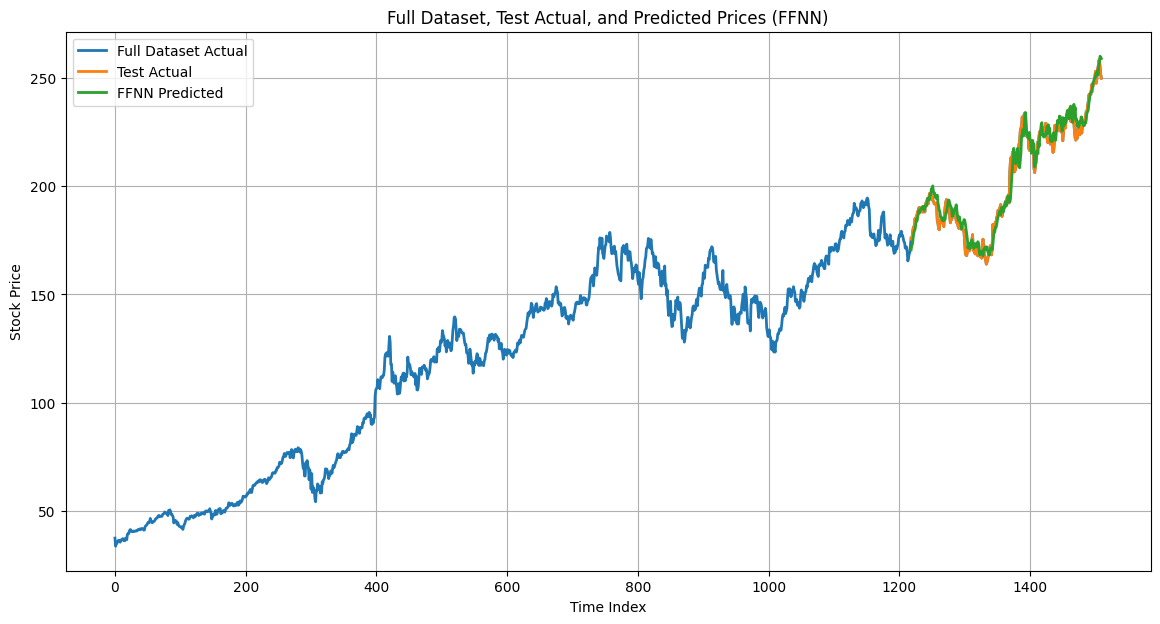

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8390 - val_loss: 0.0625
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0906 - val_loss: 0.0601
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0816 - val_loss: 0.0230
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0584 - val_loss: 0.0354
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0590 - val_loss: 0.1932
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0465 - val_loss: 0.0573
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0359 - val_loss: 0.1586
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0422 - val_loss: 0.0140
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0412 - val_loss: 0.0298
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0374 - val_loss: 0.0321
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0364 - val_loss: 0.0525
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0293 - val_

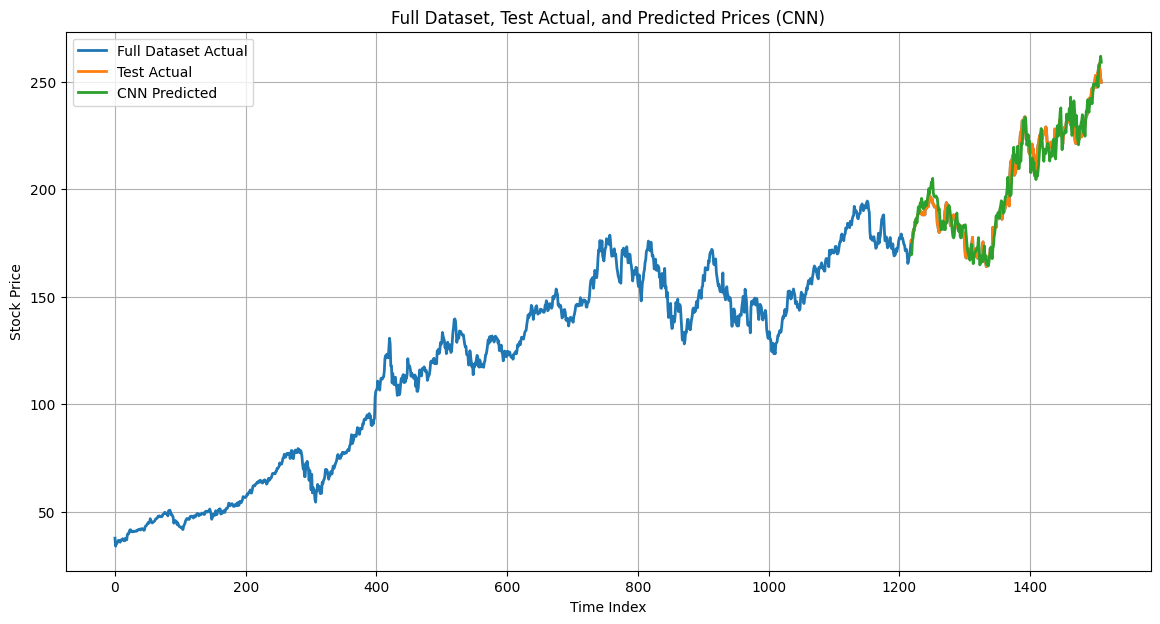

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.1183 - val_loss: 0.0382
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0257 - val_loss: 0.0355
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0194 - val_loss: 0.1011
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0182 - val_loss: 0.0127
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0197 - val_loss: 0.0289
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0148 - val_loss: 0.0480
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0150 - val_loss: 0.0708
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0167 - val_loss: 0.0207
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0145 - val_loss: 0.0461
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0133 - val_loss: 0.0170
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0145 - val_loss: 0.0254
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0

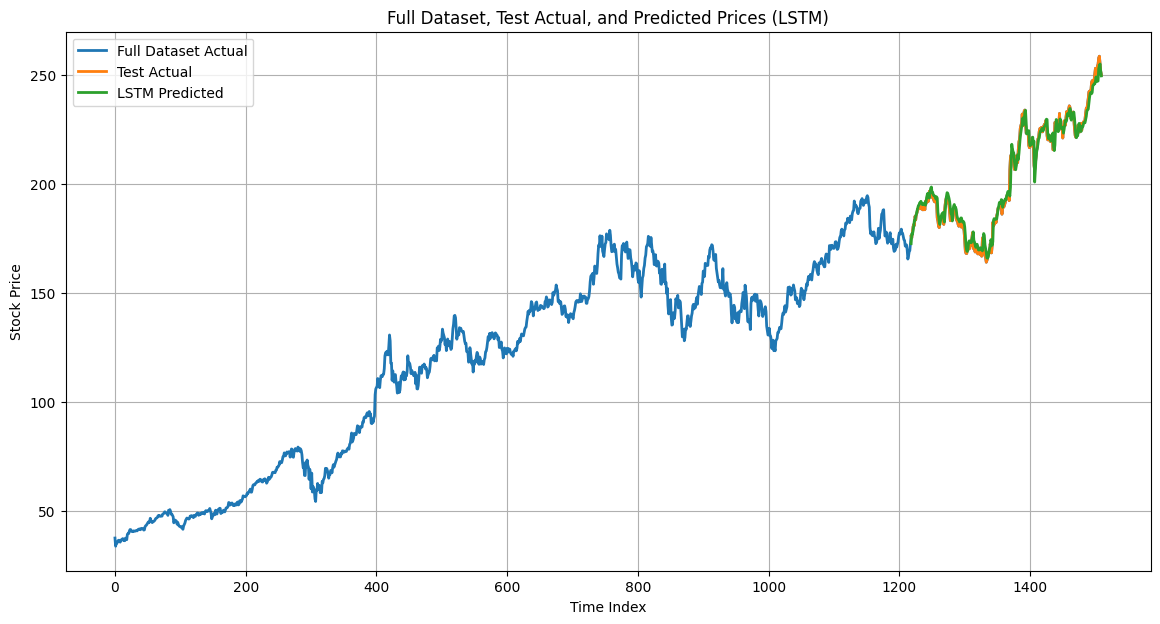

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0979 - val_loss: 0.0338
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0325 - val_loss: 0.0186
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0187 - val_loss: 0.0498
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0194 - val_loss: 0.0638
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0191 - val_loss: 0.0559
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0170 - val_loss: 0.0397
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0179 - val_loss: 0.0845
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0170 - val_loss: 0.0103
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0157 - val_loss: 0.0197
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0154 - val_loss: 0.0120
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0129 - val_loss: 0.0286
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0

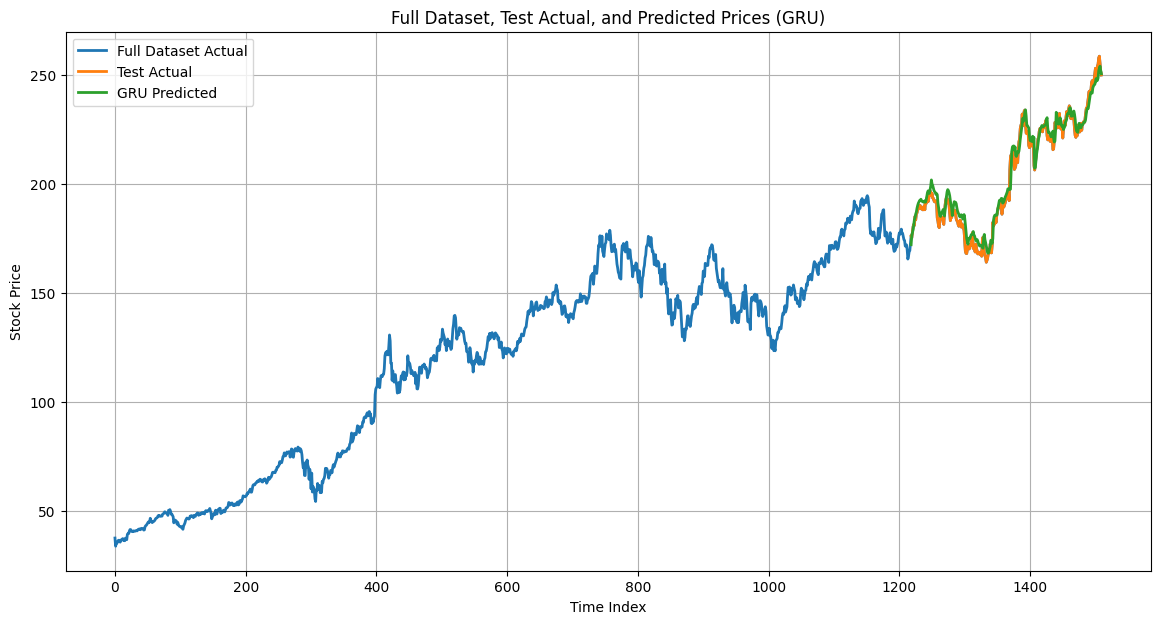

In [49]:
# Run model
for model_type in ['FFNN', 'CNN', 'LSTM', 'GRU']:
    build_and_train_model(model_type)

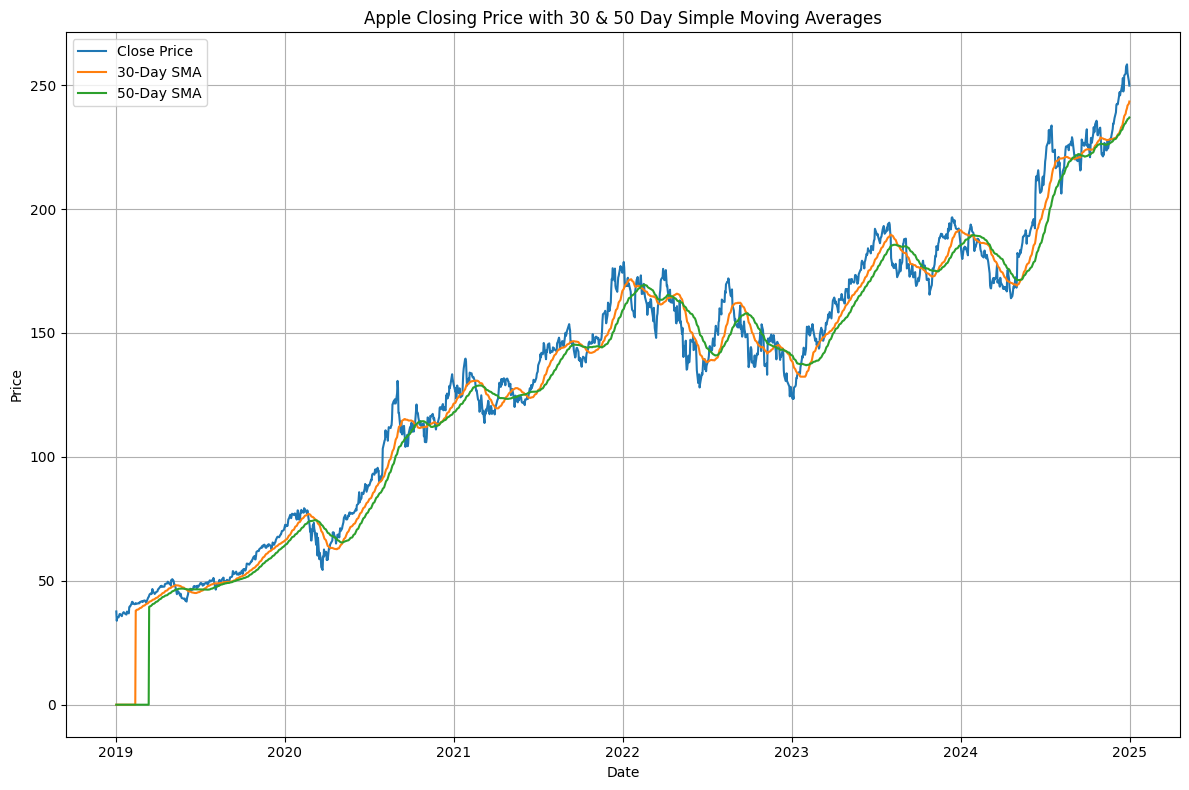

In [51]:
# Plot Closing Price with SMA_30 and SMA_50
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], data['SMA_30'], label='30-Day SMA')
plt.plot(data['Date'], data['SMA_50'], label='50-Day SMA')
plt.title('Apple Closing Price with 30 & 50 Day Simple Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
